# CS4487 Project: Image classification

## Code Reproduction
* ### Environment Requirments
  * #### Python Version >= 3.7
  * #### Pytorch Version =1.3
  * #### Nvdia GPU (for speed up training and testing)
  * #### 15GB RAM (If not enough RAM, please reduce batch_size)
* ### Run Codes
  * #### Run all the code from top to bottom
  * #### The first code cell helps install a progress bar library
  * #### Not necessary to load a saved model (This [code cell](#Load-saved-model) is not necessary to run)

## Regarding course project
* External training data is not allowed. Learning can only be performed on the 50,000 training images in **CIFAR10**
* The [**CIFAR10** dataset](https://www.cs.toronto.edu/~kriz/cifar.html) was comprised of 60,000 32 × 32 color photographs of objects from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
* Submit the results at [Kaggle CS4487 Course Project](https://www.kaggle.com/c/cs4487cp/)
* The second test set containing roughly 2,000 images (refer to test_data/y_test.npy)

## Evaluation Criteria 

* ### Classification Accuaracy:
  ### $$ Acc(f, D) = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}[y^i = f(x^i)]$$

* ### File Format:
Upload a file in CSV format, such as:

|         **Index**         |         **Category**        |
|---------------------------|-----------------------------|
| 0                         | 8                           |
| 1                         | 4                           |
| 2                         | 6                           |
| 3                         | 1                           |
| ......                    | ......                      |
| 11999                     | 2                           |

PyTorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

---
## Table of content (for quick jump)
* ### [Import Library](#Import-Library)
* ### [Data Preparation](#Data-Preparation)
* ### [Common Functions](#Common-Functions)
  * #### [Training Function](#Training-function)
  * #### [Testing Function](#Testing-function)
  * #### [Test for each category](#Test-for-each-category)
  * #### [Save Model](#Save-Model)
  * #### [Print Time](#Print-Time)
  * #### [Progress Bar](#Progress-Bar)
* ### [DenseNet (DN)](#DenseNet)
  * #### [Training](#Train-DenaseNet)
  * #### [Testing](#Test-DenseNet)
* ### [Run the model](#Run-the-model-in-project-test-data)
---
---

## Import Library

In [ ]:
%pip install progressbar2

In [1]:
import numpy as np
from numpy import *
import cv2
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import time
from _datetime import datetime
import pytz

import torch
import torchvision
from torch.utils import data
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torch.optim as optim

from progressbar import *
from sys import platform

import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

gd_root = "."  # For loacal run

basic_path = "basic_cifar_net.pth"
PATH_DPN = "DPN_cifar.pth"
PATH_Dense = "DenseNet.pth"

cuda


---
---
## Data Preparation

### Read CIFAR10 data
* The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.
* Loaded in this way, each of the batch files contains a dictionary with the following elements:
  * **data**: 
    * a 10,000 x 3,072 numpy array of uint8s. Each row of the array stores a 32 x 32 colour image. 
    * The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
    * The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
  * **labels**: 
    * a list of 10,000 numbers in the range 0 - 9. 
    * The number at index i indicates the label of the ith image in the array data.
* The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
  * **label_names** -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 
  * For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Loading and normalizing CIFAR10 to dataloader

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=256, 
                                           shuffle=True, 
                                           num_workers=8, 
                                           pin_memory=True
                                          )

testset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=32,
                                          shuffle=False, 
                                          num_workers=8,
                                          pin_memory=True
                                         )

In [5]:
train_size = len(trainset)
train_size
test_size = len(testset)
test_size
train_batch_len = len(train_loader)
train_batch_len
test_batch_len = len(test_loader)
test_batch_len

50000

10000

196

313

In [6]:
category_dict = {
    'airplane': 0, 
    'automobile': 1, 
    'bird': 2, 
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6, 
    'horse': 7, 
    'ship': 8, 
    'truck': 9
}

---
---
## Common Functions

### Mixup 
From [Facebook AI Research](https://github.com/facebookresearch/mixup-cifar10/blob/master/README.md)

In [7]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Training function

In [8]:
train_correct_rate = []
train_loss = []
learning_rate  =[]

In [9]:
def training(epoch_num: int, model_name: str, net):    
    
    final_loss = 0.0
    
    total = train_size
    
    net.train()
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        
        correct = 0
        run_loss  = 0.0
        
        train_bar = progress_bar(train_batch_len)
        
        print_time_and_msg(f"Training for epoch {epoch + 1}")
        
        for batch_idx, (inputs, targets) in enumerate(train_loader, 0):
                        
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Mixup
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 1.0)
            
            outputs = net(inputs)
            
            # forward + backward + optimize
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            run_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            
            final_loss = round(run_loss / train_batch_len, 3)
            
            train_bar.update(batch_idx)
        
        correct_rate = correct / total
        
        if epoch > 0:
            if correct_rate > max(train_correct_rate):
                save_model(model_name, net)
            else:
                pass
        if epoch + 1 == epoch_num:
            save_model(model_name, net)
        
        print_time_and_msg(f"Trained Epoch {epoch + 1}. loss: {final_loss}. Correct/Total: {correct}/{total}, Correct rate: {correct_rate}")
        
        train_loss.append(final_loss)
        train_correct_rate.append(correct_rate)
        
        scheduler.step()
        learning_rate.append(scheduler.get_lr())
        
        print()
    
    print_time_and_msg(f'Finished training total {train_size} data for {epoch_num} epoches,\nthe final loss is {final_loss}')


### Testing function

In [10]:
def testing(net):
    test_bar = progress_bar(test_batch_len)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for ti, (inputs, targets) in enumerate(test_loader):
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            test_bar.update(ti)
    print()
    print(f'Accuracy of the network on the {test_size} test images: {100 * correct / total}%')



### Test for each category

In [11]:
def test_for_each(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    test_bar = progress_bar(test_batch_len)
    
    with torch.no_grad():
        for tei, (inputs, targets) in enumerate(test_loader):
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == targets).squeeze()
            for i in range(4):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
            test_bar.update(tei)
    
    print()
    for i in range(10):
        print(f'Accuracy of {list(category_dict)[i]} : {round(100 * class_correct[i] / class_total[i], 2)}%')

### Save Model

In [12]:
def save_model(model_name: str, net):
    PATH_basic = f'{gd_root}/models/{model_name}'
    torch.save(net.state_dict(), PATH_basic)
    print_time_and_msg(f"Saved model")

### Print Time

In [13]:
def print_time_and_msg(msg: str) -> str:
    now_time = time.time()
    readable_time = datetime.fromtimestamp(now_time, pytz.timezone('Asia/Shanghai')).strftime(f'[%H:%M:%S] - {msg}')
    print(readable_time)

### Progress Bar

In [14]:
def progress_bar(max_val: int):
    bar = ProgressBar(
        widgets=[
            'Progress: ',
            Percentage(), ' ', 
            Bar('#'), ' ', 
            Timer(), ' ', 
            ETA(), ' '
        ], 
        max_value=max_val
    )
    return bar


### Plot

In [15]:
def plot_train_info():
    plt.figure(figsize=(20,10))
    x = [i for i in range(len(train_correct_rate))]
    y1 = train_correct_rate
    y2 = train_loss
    
    plt.plot(x, y1, label="train correct rate")
    plt.plot(x, y2, label="train loss")
    
    plt.legend(loc=0, numpoints=1)
    
    plt.xlabel("Epoch")

def plot_lerning_rate():
    plt.figure(figsize=(20,10))
    x = [i for i in range(len(learning_rate))]
    y = learning_rate
    plt.plot(x, y)
    plt.xlabel("Epoch")

# plot_train_info()

### Unpickle CIFAR data

In [16]:
def unpickle_cifar10(file: str) -> dict:
    full_name = f"{gd_root}/data/cifar-10-batches-py/{file}"
    
    with open(full_name, 'rb') as fi:
        cifar10_dict = pickle.load(fi, encoding='bytes')
    return cifar10_dict

cifar_meta = unpickle_cifar10("batches.meta")
cifar_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

---
---
## DenseNet

In [17]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

### Train DenaseNet

#### Go to [training function](#Training-function)

In [18]:
densenet_net = DenseNet121()
densenet_net.to(device)
if device == 'cuda':
    densenet_net = torch.nn.DataParallel(densenet_net)
    cudnn.benchmark = True

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet_net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

### Load saved model

In [20]:
model_PATH = f"{gd_root}/models/{PATH_Dense}"
densenet_net.load_state_dict(torch.load(model_PATH))
print_time_and_msg(f"Loaded model: {PATH_Dense}")

<All keys matched successfully>

[12:58:37] - Loaded model: DenseNet.pth


In [20]:
epoches = 300

In [21]:
print_time_and_msg(f"Start training Dense Net for {epoches} epoches\n")
training(epoch_num=epoches, model_name=PATH_Dense, net=densenet_net)

[13:00:43] - Start training Dense Net for 300 epoches

[13:00:43] - Training for epoch 1


Progress:  99% |####################### | Elapsed Time: 0:00:47 ETA:   0:00:00 

[13:01:35] - Trained Epoch 1. loss: 1.847. Correct/Total: 14026/50000, Correct rate: 0.28052

[13:01:35] - Training for epoch 2


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:02:22] - Saved model
[13:02:22] - Trained Epoch 2. loss: 1.626. Correct/Total: 17932/50000, Correct rate: 0.35864

[13:02:22] - Training for epoch 3


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:03:08] - Saved model
[13:03:08] - Trained Epoch 3. loss: 1.427. Correct/Total: 19082/50000, Correct rate: 0.38164

[13:03:08] - Training for epoch 4


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:03:55] - Saved model
[13:03:55] - Trained Epoch 4. loss: 1.422. Correct/Total: 20690/50000, Correct rate: 0.4138

[13:03:55] - Training for epoch 5


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:04:42] - Saved model
[13:04:42] - Trained Epoch 5. loss: 1.338. Correct/Total: 20894/50000, Correct rate: 0.41788

[13:04:42] - Training for epoch 6


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:05:28] - Saved model
[13:05:28] - Trained Epoch 6. loss: 1.269. Correct/Total: 22959/50000, Correct rate: 0.45918

[13:05:28] - Training for epoch 7


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:06:15] - Saved model
[13:06:15] - Trained Epoch 7. loss: 1.236. Correct/Total: 24880/50000, Correct rate: 0.4976

[13:06:15] - Training for epoch 8


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:07:02] - Trained Epoch 8. loss: 1.181. Correct/Total: 22249/50000, Correct rate: 0.44498

[13:07:02] - Training for epoch 9


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:07:49] - Trained Epoch 9. loss: 1.196. Correct/Total: 23553/50000, Correct rate: 0.47106

[13:07:49] - Training for epoch 10


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:08:35] - Trained Epoch 10. loss: 1.128. Correct/Total: 21825/50000, Correct rate: 0.4365

[13:08:35] - Training for epoch 11


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:09:22] - Trained Epoch 11. loss: 1.144. Correct/Total: 24064/50000, Correct rate: 0.48128

[13:09:22] - Training for epoch 12


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:10:08] - Trained Epoch 12. loss: 1.151. Correct/Total: 24382/50000, Correct rate: 0.48764

[13:10:08] - Training for epoch 13


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:10:55] - Trained Epoch 13. loss: 1.127. Correct/Total: 24513/50000, Correct rate: 0.49026

[13:10:55] - Training for epoch 14


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:11:42] - Trained Epoch 14. loss: 1.073. Correct/Total: 24330/50000, Correct rate: 0.4866

[13:11:42] - Training for epoch 15


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:12:28] - Trained Epoch 15. loss: 1.133. Correct/Total: 23881/50000, Correct rate: 0.47762

[13:12:28] - Training for epoch 16


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:13:15] - Trained Epoch 16. loss: 1.029. Correct/Total: 22324/50000, Correct rate: 0.44648

[13:13:15] - Training for epoch 17


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:14:02] - Trained Epoch 17. loss: 1.051. Correct/Total: 23249/50000, Correct rate: 0.46498

[13:14:02] - Training for epoch 18


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:14:48] - Trained Epoch 18. loss: 1.082. Correct/Total: 24474/50000, Correct rate: 0.48948

[13:14:48] - Training for epoch 19


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:15:35] - Saved model
[13:15:35] - Trained Epoch 19. loss: 1.092. Correct/Total: 25155/50000, Correct rate: 0.5031

[13:15:35] - Training for epoch 20


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:16:21] - Trained Epoch 20. loss: 0.998. Correct/Total: 25032/50000, Correct rate: 0.50064

[13:16:21] - Training for epoch 21


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:17:08] - Saved model
[13:17:08] - Trained Epoch 21. loss: 1.051. Correct/Total: 25578/50000, Correct rate: 0.51156

[13:17:08] - Training for epoch 22


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:17:55] - Trained Epoch 22. loss: 0.99. Correct/Total: 25265/50000, Correct rate: 0.5053

[13:17:55] - Training for epoch 23


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:18:41] - Trained Epoch 23. loss: 1.002. Correct/Total: 25470/50000, Correct rate: 0.5094

[13:18:41] - Training for epoch 24


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:19:28] - Saved model
[13:19:28] - Trained Epoch 24. loss: 0.993. Correct/Total: 25711/50000, Correct rate: 0.51422

[13:19:28] - Training for epoch 25


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:20:14] - Trained Epoch 25. loss: 0.961. Correct/Total: 23095/50000, Correct rate: 0.4619

[13:20:14] - Training for epoch 26


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:21:01] - Trained Epoch 26. loss: 0.998. Correct/Total: 25369/50000, Correct rate: 0.50738

[13:21:01] - Training for epoch 27


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:21:47] - Saved model
[13:21:47] - Trained Epoch 27. loss: 0.944. Correct/Total: 26112/50000, Correct rate: 0.52224

[13:21:47] - Training for epoch 28


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:22:34] - Trained Epoch 28. loss: 0.994. Correct/Total: 25807/50000, Correct rate: 0.51614

[13:22:34] - Training for epoch 29


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:23:20] - Trained Epoch 29. loss: 0.996. Correct/Total: 25609/50000, Correct rate: 0.51218

[13:23:20] - Training for epoch 30


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:24:07] - Saved model
[13:24:07] - Trained Epoch 30. loss: 0.968. Correct/Total: 27699/50000, Correct rate: 0.55398

[13:24:07] - Training for epoch 31


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:24:53] - Trained Epoch 31. loss: 0.975. Correct/Total: 23699/50000, Correct rate: 0.47398

[13:24:53] - Training for epoch 32


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:25:40] - Trained Epoch 32. loss: 0.98. Correct/Total: 24523/50000, Correct rate: 0.49046

[13:25:40] - Training for epoch 33


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:26:26] - Trained Epoch 33. loss: 0.932. Correct/Total: 27284/50000, Correct rate: 0.54568

[13:26:26] - Training for epoch 34


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:27:13] - Trained Epoch 34. loss: 1.006. Correct/Total: 27442/50000, Correct rate: 0.54884

[13:27:13] - Training for epoch 35


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:28:00] - Trained Epoch 35. loss: 0.909. Correct/Total: 25561/50000, Correct rate: 0.51122

[13:28:00] - Training for epoch 36


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:28:46] - Trained Epoch 36. loss: 0.997. Correct/Total: 25060/50000, Correct rate: 0.5012

[13:28:46] - Training for epoch 37


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:29:33] - Trained Epoch 37. loss: 0.943. Correct/Total: 24664/50000, Correct rate: 0.49328

[13:29:33] - Training for epoch 38


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:30:19] - Trained Epoch 38. loss: 0.968. Correct/Total: 24097/50000, Correct rate: 0.48194

[13:30:19] - Training for epoch 39


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:31:05] - Trained Epoch 39. loss: 0.963. Correct/Total: 26449/50000, Correct rate: 0.52898

[13:31:05] - Training for epoch 40


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:31:52] - Trained Epoch 40. loss: 1.024. Correct/Total: 24940/50000, Correct rate: 0.4988

[13:31:52] - Training for epoch 41


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:32:39] - Trained Epoch 41. loss: 0.991. Correct/Total: 27243/50000, Correct rate: 0.54486

[13:32:39] - Training for epoch 42


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:33:25] - Trained Epoch 42. loss: 0.979. Correct/Total: 26585/50000, Correct rate: 0.5317

[13:33:25] - Training for epoch 43


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:34:12] - Trained Epoch 43. loss: 1.022. Correct/Total: 23815/50000, Correct rate: 0.4763

[13:34:12] - Training for epoch 44


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:34:58] - Trained Epoch 44. loss: 0.997. Correct/Total: 24941/50000, Correct rate: 0.49882

[13:34:58] - Training for epoch 45


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:35:45] - Trained Epoch 45. loss: 0.986. Correct/Total: 26081/50000, Correct rate: 0.52162

[13:35:45] - Training for epoch 46


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:36:31] - Trained Epoch 46. loss: 1.038. Correct/Total: 23372/50000, Correct rate: 0.46744

[13:36:31] - Training for epoch 47


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:37:18] - Trained Epoch 47. loss: 1.02. Correct/Total: 24693/50000, Correct rate: 0.49386

[13:37:18] - Training for epoch 48


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:38:05] - Trained Epoch 48. loss: 0.989. Correct/Total: 24916/50000, Correct rate: 0.49832

[13:38:05] - Training for epoch 49


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:38:51] - Trained Epoch 49. loss: 0.995. Correct/Total: 23671/50000, Correct rate: 0.47342

[13:38:51] - Training for epoch 50


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:39:38] - Trained Epoch 50. loss: 1.044. Correct/Total: 26214/50000, Correct rate: 0.52428

[13:39:38] - Training for epoch 51


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:40:24] - Trained Epoch 51. loss: 0.992. Correct/Total: 25491/50000, Correct rate: 0.50982

[13:40:24] - Training for epoch 52


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:41:11] - Trained Epoch 52. loss: 1.018. Correct/Total: 24277/50000, Correct rate: 0.48554

[13:41:11] - Training for epoch 53


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:41:58] - Trained Epoch 53. loss: 1.028. Correct/Total: 23757/50000, Correct rate: 0.47514

[13:41:58] - Training for epoch 54


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:42:44] - Trained Epoch 54. loss: 1.001. Correct/Total: 25300/50000, Correct rate: 0.506

[13:42:44] - Training for epoch 55


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:43:31] - Trained Epoch 55. loss: 1.012. Correct/Total: 23843/50000, Correct rate: 0.47686

[13:43:31] - Training for epoch 56


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:44:17] - Trained Epoch 56. loss: 1.052. Correct/Total: 23899/50000, Correct rate: 0.47798

[13:44:17] - Training for epoch 57


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:45:04] - Trained Epoch 57. loss: 1.034. Correct/Total: 26391/50000, Correct rate: 0.52782

[13:45:04] - Training for epoch 58


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:45:50] - Trained Epoch 58. loss: 1.028. Correct/Total: 24512/50000, Correct rate: 0.49024

[13:45:50] - Training for epoch 59


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:46:37] - Trained Epoch 59. loss: 1.006. Correct/Total: 26653/50000, Correct rate: 0.53306

[13:46:37] - Training for epoch 60


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:47:24] - Trained Epoch 60. loss: 1.016. Correct/Total: 26546/50000, Correct rate: 0.53092

[13:47:24] - Training for epoch 61


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:48:10] - Trained Epoch 61. loss: 1.014. Correct/Total: 24941/50000, Correct rate: 0.49882

[13:48:10] - Training for epoch 62


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:48:57] - Trained Epoch 62. loss: 0.98. Correct/Total: 26565/50000, Correct rate: 0.5313

[13:48:57] - Training for epoch 63


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:49:43] - Trained Epoch 63. loss: 1.056. Correct/Total: 22235/50000, Correct rate: 0.4447

[13:49:43] - Training for epoch 64


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:50:30] - Trained Epoch 64. loss: 0.975. Correct/Total: 26815/50000, Correct rate: 0.5363

[13:50:30] - Training for epoch 65


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:51:17] - Trained Epoch 65. loss: 0.999. Correct/Total: 25846/50000, Correct rate: 0.51692

[13:51:17] - Training for epoch 66


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:52:03] - Trained Epoch 66. loss: 0.992. Correct/Total: 24768/50000, Correct rate: 0.49536

[13:52:03] - Training for epoch 67


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:52:50] - Trained Epoch 67. loss: 0.963. Correct/Total: 25633/50000, Correct rate: 0.51266

[13:52:50] - Training for epoch 68


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:53:37] - Trained Epoch 68. loss: 0.967. Correct/Total: 27223/50000, Correct rate: 0.54446

[13:53:37] - Training for epoch 69


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:54:24] - Trained Epoch 69. loss: 0.942. Correct/Total: 25426/50000, Correct rate: 0.50852

[13:54:24] - Training for epoch 70


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:55:10] - Trained Epoch 70. loss: 0.943. Correct/Total: 25621/50000, Correct rate: 0.51242

[13:55:10] - Training for epoch 71


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:55:57] - Trained Epoch 71. loss: 0.977. Correct/Total: 25690/50000, Correct rate: 0.5138

[13:55:57] - Training for epoch 72


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:56:44] - Saved model
[13:56:44] - Trained Epoch 72. loss: 0.971. Correct/Total: 28281/50000, Correct rate: 0.56562

[13:56:44] - Training for epoch 73


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:57:30] - Trained Epoch 73. loss: 0.909. Correct/Total: 25211/50000, Correct rate: 0.50422

[13:57:30] - Training for epoch 74


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:58:17] - Trained Epoch 74. loss: 0.879. Correct/Total: 28182/50000, Correct rate: 0.56364

[13:58:17] - Training for epoch 75


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:59:04] - Trained Epoch 75. loss: 0.909. Correct/Total: 25909/50000, Correct rate: 0.51818

[13:59:04] - Training for epoch 76


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[13:59:50] - Trained Epoch 76. loss: 0.903. Correct/Total: 27677/50000, Correct rate: 0.55354

[13:59:50] - Training for epoch 77


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:00:37] - Trained Epoch 77. loss: 0.869. Correct/Total: 26118/50000, Correct rate: 0.52236

[14:00:37] - Training for epoch 78


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:01:23] - Trained Epoch 78. loss: 0.831. Correct/Total: 27017/50000, Correct rate: 0.54034

[14:01:23] - Training for epoch 79


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:02:10] - Trained Epoch 79. loss: 0.847. Correct/Total: 27467/50000, Correct rate: 0.54934

[14:02:10] - Training for epoch 80


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:02:56] - Trained Epoch 80. loss: 0.892. Correct/Total: 26658/50000, Correct rate: 0.53316

[14:02:56] - Training for epoch 81


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:03:43] - Trained Epoch 81. loss: 0.871. Correct/Total: 27263/50000, Correct rate: 0.54526

[14:03:43] - Training for epoch 82


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:04:29] - Trained Epoch 82. loss: 0.844. Correct/Total: 26700/50000, Correct rate: 0.534

[14:04:29] - Training for epoch 83


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:05:17] - Trained Epoch 83. loss: 0.815. Correct/Total: 27723/50000, Correct rate: 0.55446

[14:05:17] - Training for epoch 84


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:06:03] - Trained Epoch 84. loss: 0.87. Correct/Total: 27073/50000, Correct rate: 0.54146

[14:06:03] - Training for epoch 85


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:06:50] - Trained Epoch 85. loss: 0.859. Correct/Total: 26756/50000, Correct rate: 0.53512

[14:06:50] - Training for epoch 86


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:07:36] - Trained Epoch 86. loss: 0.878. Correct/Total: 26735/50000, Correct rate: 0.5347

[14:07:36] - Training for epoch 87


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:08:23] - Trained Epoch 87. loss: 0.829. Correct/Total: 26423/50000, Correct rate: 0.52846

[14:08:23] - Training for epoch 88


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:09:10] - Saved model
[14:09:10] - Trained Epoch 88. loss: 0.81. Correct/Total: 29057/50000, Correct rate: 0.58114

[14:09:10] - Training for epoch 89


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:09:56] - Trained Epoch 89. loss: 0.831. Correct/Total: 27464/50000, Correct rate: 0.54928

[14:09:56] - Training for epoch 90


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:10:43] - Trained Epoch 90. loss: 0.813. Correct/Total: 24983/50000, Correct rate: 0.49966

[14:10:43] - Training for epoch 91


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:11:30] - Trained Epoch 91. loss: 0.801. Correct/Total: 27393/50000, Correct rate: 0.54786

[14:11:30] - Training for epoch 92


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:12:17] - Trained Epoch 92. loss: 0.803. Correct/Total: 25791/50000, Correct rate: 0.51582

[14:12:17] - Training for epoch 93


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:13:03] - Trained Epoch 93. loss: 0.804. Correct/Total: 27212/50000, Correct rate: 0.54424

[14:13:03] - Training for epoch 94


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:13:50] - Trained Epoch 94. loss: 0.817. Correct/Total: 25326/50000, Correct rate: 0.50652

[14:13:50] - Training for epoch 95


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:14:36] - Trained Epoch 95. loss: 0.835. Correct/Total: 27510/50000, Correct rate: 0.5502

[14:14:36] - Training for epoch 96


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:15:23] - Trained Epoch 96. loss: 0.831. Correct/Total: 25622/50000, Correct rate: 0.51244

[14:15:23] - Training for epoch 97


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:16:10] - Trained Epoch 97. loss: 0.82. Correct/Total: 27414/50000, Correct rate: 0.54828

[14:16:10] - Training for epoch 98


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:16:56] - Trained Epoch 98. loss: 0.864. Correct/Total: 28185/50000, Correct rate: 0.5637

[14:16:56] - Training for epoch 99


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:17:44] - Trained Epoch 99. loss: 0.81. Correct/Total: 25500/50000, Correct rate: 0.51

[14:17:44] - Training for epoch 100


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:18:30] - Trained Epoch 100. loss: 0.89. Correct/Total: 27833/50000, Correct rate: 0.55666

[14:18:30] - Training for epoch 101


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:19:17] - Trained Epoch 101. loss: 0.893. Correct/Total: 23452/50000, Correct rate: 0.46904

[14:19:17] - Training for epoch 102


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:20:04] - Trained Epoch 102. loss: 0.803. Correct/Total: 27130/50000, Correct rate: 0.5426

[14:20:04] - Training for epoch 103


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:20:50] - Trained Epoch 103. loss: 0.853. Correct/Total: 27060/50000, Correct rate: 0.5412

[14:20:50] - Training for epoch 104


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:21:37] - Trained Epoch 104. loss: 0.875. Correct/Total: 26242/50000, Correct rate: 0.52484

[14:21:37] - Training for epoch 105


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:22:23] - Trained Epoch 105. loss: 0.875. Correct/Total: 26018/50000, Correct rate: 0.52036

[14:22:23] - Training for epoch 106


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:23:10] - Trained Epoch 106. loss: 0.872. Correct/Total: 24258/50000, Correct rate: 0.48516

[14:23:10] - Training for epoch 107


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:23:57] - Trained Epoch 107. loss: 0.86. Correct/Total: 27426/50000, Correct rate: 0.54852

[14:23:57] - Training for epoch 108


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:24:44] - Trained Epoch 108. loss: 0.878. Correct/Total: 26925/50000, Correct rate: 0.5385

[14:24:44] - Training for epoch 109


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:25:30] - Trained Epoch 109. loss: 0.916. Correct/Total: 24773/50000, Correct rate: 0.49546

[14:25:30] - Training for epoch 110


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:26:17] - Trained Epoch 110. loss: 0.921. Correct/Total: 25826/50000, Correct rate: 0.51652

[14:26:17] - Training for epoch 111


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:27:03] - Trained Epoch 111. loss: 0.901. Correct/Total: 26128/50000, Correct rate: 0.52256

[14:27:03] - Training for epoch 112


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:27:50] - Trained Epoch 112. loss: 0.921. Correct/Total: 27669/50000, Correct rate: 0.55338

[14:27:50] - Training for epoch 113


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:28:36] - Trained Epoch 113. loss: 0.942. Correct/Total: 27573/50000, Correct rate: 0.55146

[14:28:36] - Training for epoch 114


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:29:23] - Trained Epoch 114. loss: 0.87. Correct/Total: 25715/50000, Correct rate: 0.5143

[14:29:23] - Training for epoch 115


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:30:10] - Trained Epoch 115. loss: 0.943. Correct/Total: 26609/50000, Correct rate: 0.53218

[14:30:10] - Training for epoch 116


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:30:57] - Trained Epoch 116. loss: 0.863. Correct/Total: 24922/50000, Correct rate: 0.49844

[14:30:57] - Training for epoch 117


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:31:44] - Trained Epoch 117. loss: 0.869. Correct/Total: 26657/50000, Correct rate: 0.53314

[14:31:44] - Training for epoch 118


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:32:30] - Trained Epoch 118. loss: 0.892. Correct/Total: 26066/50000, Correct rate: 0.52132

[14:32:30] - Training for epoch 119


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:33:17] - Trained Epoch 119. loss: 0.863. Correct/Total: 25731/50000, Correct rate: 0.51462

[14:33:17] - Training for epoch 120


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:34:03] - Trained Epoch 120. loss: 0.933. Correct/Total: 25464/50000, Correct rate: 0.50928

[14:34:03] - Training for epoch 121


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:34:50] - Trained Epoch 121. loss: 0.901. Correct/Total: 25904/50000, Correct rate: 0.51808

[14:34:50] - Training for epoch 122


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:35:36] - Trained Epoch 122. loss: 0.919. Correct/Total: 26938/50000, Correct rate: 0.53876

[14:35:36] - Training for epoch 123


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:36:24] - Trained Epoch 123. loss: 0.899. Correct/Total: 24858/50000, Correct rate: 0.49716

[14:36:24] - Training for epoch 124


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:37:10] - Trained Epoch 124. loss: 0.893. Correct/Total: 26111/50000, Correct rate: 0.52222

[14:37:10] - Training for epoch 125


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:37:57] - Trained Epoch 125. loss: 0.883. Correct/Total: 25815/50000, Correct rate: 0.5163

[14:37:57] - Training for epoch 126


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:38:43] - Trained Epoch 126. loss: 0.902. Correct/Total: 25891/50000, Correct rate: 0.51782

[14:38:43] - Training for epoch 127


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:39:30] - Trained Epoch 127. loss: 0.871. Correct/Total: 26198/50000, Correct rate: 0.52396

[14:39:30] - Training for epoch 128


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:40:17] - Trained Epoch 128. loss: 0.866. Correct/Total: 27515/50000, Correct rate: 0.5503

[14:40:17] - Training for epoch 129


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:41:03] - Trained Epoch 129. loss: 0.913. Correct/Total: 28612/50000, Correct rate: 0.57224

[14:41:03] - Training for epoch 130


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:41:50] - Trained Epoch 130. loss: 0.879. Correct/Total: 27392/50000, Correct rate: 0.54784

[14:41:50] - Training for epoch 131


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:42:36] - Trained Epoch 131. loss: 0.904. Correct/Total: 27145/50000, Correct rate: 0.5429

[14:42:36] - Training for epoch 132


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:43:23] - Trained Epoch 132. loss: 0.898. Correct/Total: 25666/50000, Correct rate: 0.51332

[14:43:23] - Training for epoch 133


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:44:09] - Trained Epoch 133. loss: 0.888. Correct/Total: 26715/50000, Correct rate: 0.5343

[14:44:09] - Training for epoch 134


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:44:56] - Trained Epoch 134. loss: 0.797. Correct/Total: 26786/50000, Correct rate: 0.53572

[14:44:56] - Training for epoch 135


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:45:43] - Trained Epoch 135. loss: 0.85. Correct/Total: 29051/50000, Correct rate: 0.58102

[14:45:43] - Training for epoch 136


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:46:29] - Trained Epoch 136. loss: 0.826. Correct/Total: 25718/50000, Correct rate: 0.51436

[14:46:29] - Training for epoch 137


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:47:16] - Trained Epoch 137. loss: 0.79. Correct/Total: 26577/50000, Correct rate: 0.53154

[14:47:16] - Training for epoch 138


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:48:02] - Trained Epoch 138. loss: 0.865. Correct/Total: 26843/50000, Correct rate: 0.53686

[14:48:02] - Training for epoch 139


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:48:49] - Trained Epoch 139. loss: 0.832. Correct/Total: 26453/50000, Correct rate: 0.52906

[14:48:49] - Training for epoch 140


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:49:36] - Trained Epoch 140. loss: 0.798. Correct/Total: 23970/50000, Correct rate: 0.4794

[14:49:36] - Training for epoch 141


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:50:22] - Trained Epoch 141. loss: 0.807. Correct/Total: 27730/50000, Correct rate: 0.5546

[14:50:22] - Training for epoch 142


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:51:09] - Trained Epoch 142. loss: 0.834. Correct/Total: 27966/50000, Correct rate: 0.55932

[14:51:09] - Training for epoch 143


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:51:55] - Trained Epoch 143. loss: 0.752. Correct/Total: 26810/50000, Correct rate: 0.5362

[14:51:55] - Training for epoch 144


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:52:42] - Saved model
[14:52:42] - Trained Epoch 144. loss: 0.8. Correct/Total: 29298/50000, Correct rate: 0.58596

[14:52:42] - Training for epoch 145


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:53:28] - Trained Epoch 145. loss: 0.775. Correct/Total: 25807/50000, Correct rate: 0.51614

[14:53:28] - Training for epoch 146


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:54:15] - Trained Epoch 146. loss: 0.742. Correct/Total: 28632/50000, Correct rate: 0.57264

[14:54:15] - Training for epoch 147


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:55:02] - Trained Epoch 147. loss: 0.764. Correct/Total: 27721/50000, Correct rate: 0.55442

[14:55:02] - Training for epoch 148


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:55:48] - Trained Epoch 148. loss: 0.744. Correct/Total: 28797/50000, Correct rate: 0.57594

[14:55:48] - Training for epoch 149


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:56:35] - Trained Epoch 149. loss: 0.785. Correct/Total: 25854/50000, Correct rate: 0.51708

[14:56:35] - Training for epoch 150


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:57:21] - Trained Epoch 150. loss: 0.763. Correct/Total: 26180/50000, Correct rate: 0.5236

[14:57:21] - Training for epoch 151


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:58:07] - Trained Epoch 151. loss: 0.768. Correct/Total: 27443/50000, Correct rate: 0.54886

[14:58:07] - Training for epoch 152


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:58:54] - Trained Epoch 152. loss: 0.766. Correct/Total: 26700/50000, Correct rate: 0.534

[14:58:54] - Training for epoch 153


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[14:59:40] - Trained Epoch 153. loss: 0.819. Correct/Total: 24778/50000, Correct rate: 0.49556

[14:59:40] - Training for epoch 154


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:00:27] - Trained Epoch 154. loss: 0.755. Correct/Total: 26518/50000, Correct rate: 0.53036

[15:00:27] - Training for epoch 155


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:01:13] - Trained Epoch 155. loss: 0.764. Correct/Total: 27139/50000, Correct rate: 0.54278

[15:01:13] - Training for epoch 156


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:02:00] - Trained Epoch 156. loss: 0.802. Correct/Total: 27654/50000, Correct rate: 0.55308

[15:02:00] - Training for epoch 157


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:02:47] - Trained Epoch 157. loss: 0.761. Correct/Total: 26571/50000, Correct rate: 0.53142

[15:02:47] - Training for epoch 158


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:03:33] - Trained Epoch 158. loss: 0.778. Correct/Total: 26911/50000, Correct rate: 0.53822

[15:03:33] - Training for epoch 159


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:04:20] - Trained Epoch 159. loss: 0.789. Correct/Total: 24639/50000, Correct rate: 0.49278

[15:04:20] - Training for epoch 160


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:05:06] - Trained Epoch 160. loss: 0.772. Correct/Total: 25552/50000, Correct rate: 0.51104

[15:05:06] - Training for epoch 161


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:05:53] - Trained Epoch 161. loss: 0.771. Correct/Total: 27730/50000, Correct rate: 0.5546

[15:05:53] - Training for epoch 162


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:06:40] - Trained Epoch 162. loss: 0.781. Correct/Total: 26465/50000, Correct rate: 0.5293

[15:06:40] - Training for epoch 163


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:07:26] - Trained Epoch 163. loss: 0.818. Correct/Total: 27712/50000, Correct rate: 0.55424

[15:07:26] - Training for epoch 164


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:08:13] - Trained Epoch 164. loss: 0.81. Correct/Total: 26851/50000, Correct rate: 0.53702

[15:08:13] - Training for epoch 165


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:09:00] - Trained Epoch 165. loss: 0.793. Correct/Total: 26123/50000, Correct rate: 0.52246

[15:09:00] - Training for epoch 166


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:09:46] - Trained Epoch 166. loss: 0.844. Correct/Total: 24103/50000, Correct rate: 0.48206

[15:09:46] - Training for epoch 167


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:10:33] - Trained Epoch 167. loss: 0.815. Correct/Total: 25970/50000, Correct rate: 0.5194

[15:10:33] - Training for epoch 168


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:11:19] - Trained Epoch 168. loss: 0.837. Correct/Total: 24710/50000, Correct rate: 0.4942

[15:11:19] - Training for epoch 169


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:12:06] - Trained Epoch 169. loss: 0.829. Correct/Total: 26991/50000, Correct rate: 0.53982

[15:12:06] - Training for epoch 170


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:12:52] - Trained Epoch 170. loss: 0.849. Correct/Total: 25792/50000, Correct rate: 0.51584

[15:12:52] - Training for epoch 171


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:13:39] - Trained Epoch 171. loss: 0.817. Correct/Total: 25292/50000, Correct rate: 0.50584

[15:13:39] - Training for epoch 172


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:14:25] - Trained Epoch 172. loss: 0.859. Correct/Total: 26091/50000, Correct rate: 0.52182

[15:14:25] - Training for epoch 173


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:15:12] - Trained Epoch 173. loss: 0.869. Correct/Total: 25935/50000, Correct rate: 0.5187

[15:15:12] - Training for epoch 174


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:15:58] - Trained Epoch 174. loss: 0.868. Correct/Total: 27149/50000, Correct rate: 0.54298

[15:15:58] - Training for epoch 175


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:16:45] - Trained Epoch 175. loss: 0.863. Correct/Total: 27641/50000, Correct rate: 0.55282

[15:16:45] - Training for epoch 176


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:17:32] - Trained Epoch 176. loss: 0.851. Correct/Total: 27471/50000, Correct rate: 0.54942

[15:17:32] - Training for epoch 177


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:18:18] - Trained Epoch 177. loss: 0.903. Correct/Total: 26825/50000, Correct rate: 0.5365

[15:18:18] - Training for epoch 178


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:19:05] - Trained Epoch 178. loss: 0.881. Correct/Total: 25869/50000, Correct rate: 0.51738

[15:19:05] - Training for epoch 179


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:19:51] - Trained Epoch 179. loss: 0.883. Correct/Total: 26500/50000, Correct rate: 0.53

[15:19:51] - Training for epoch 180


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:20:38] - Trained Epoch 180. loss: 0.877. Correct/Total: 27633/50000, Correct rate: 0.55266

[15:20:38] - Training for epoch 181


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:21:25] - Trained Epoch 181. loss: 0.876. Correct/Total: 24840/50000, Correct rate: 0.4968

[15:21:25] - Training for epoch 182


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:22:11] - Trained Epoch 182. loss: 0.831. Correct/Total: 27109/50000, Correct rate: 0.54218

[15:22:11] - Training for epoch 183


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:22:58] - Trained Epoch 183. loss: 0.875. Correct/Total: 27208/50000, Correct rate: 0.54416

[15:22:58] - Training for epoch 184


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:23:44] - Trained Epoch 184. loss: 0.883. Correct/Total: 25975/50000, Correct rate: 0.5195

[15:23:44] - Training for epoch 185


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:24:31] - Trained Epoch 185. loss: 0.84. Correct/Total: 24859/50000, Correct rate: 0.49718

[15:24:31] - Training for epoch 186


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:25:17] - Trained Epoch 186. loss: 0.838. Correct/Total: 24885/50000, Correct rate: 0.4977

[15:25:17] - Training for epoch 187


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:26:04] - Trained Epoch 187. loss: 0.811. Correct/Total: 27060/50000, Correct rate: 0.5412

[15:26:04] - Training for epoch 188


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:26:50] - Trained Epoch 188. loss: 0.867. Correct/Total: 25505/50000, Correct rate: 0.5101

[15:26:50] - Training for epoch 189


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:27:37] - Trained Epoch 189. loss: 0.802. Correct/Total: 24979/50000, Correct rate: 0.49958

[15:27:37] - Training for epoch 190


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:28:24] - Trained Epoch 190. loss: 0.885. Correct/Total: 25092/50000, Correct rate: 0.50184

[15:28:24] - Training for epoch 191


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:29:10] - Trained Epoch 191. loss: 0.836. Correct/Total: 26451/50000, Correct rate: 0.52902

[15:29:10] - Training for epoch 192


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:29:57] - Trained Epoch 192. loss: 0.843. Correct/Total: 24433/50000, Correct rate: 0.48866

[15:29:57] - Training for epoch 193


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:30:43] - Trained Epoch 193. loss: 0.789. Correct/Total: 27181/50000, Correct rate: 0.54362

[15:30:43] - Training for epoch 194


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:31:30] - Trained Epoch 194. loss: 0.808. Correct/Total: 26914/50000, Correct rate: 0.53828

[15:31:30] - Training for epoch 195


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:32:16] - Trained Epoch 195. loss: 0.802. Correct/Total: 27286/50000, Correct rate: 0.54572

[15:32:16] - Training for epoch 196


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:33:03] - Trained Epoch 196. loss: 0.768. Correct/Total: 28239/50000, Correct rate: 0.56478

[15:33:03] - Training for epoch 197


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:33:49] - Trained Epoch 197. loss: 0.777. Correct/Total: 26480/50000, Correct rate: 0.5296

[15:33:49] - Training for epoch 198


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:34:36] - Trained Epoch 198. loss: 0.792. Correct/Total: 29112/50000, Correct rate: 0.58224

[15:34:36] - Training for epoch 199


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:35:22] - Trained Epoch 199. loss: 0.736. Correct/Total: 26822/50000, Correct rate: 0.53644

[15:35:22] - Training for epoch 200


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:36:09] - Trained Epoch 200. loss: 0.805. Correct/Total: 25532/50000, Correct rate: 0.51064

[15:36:09] - Training for epoch 201


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:36:55] - Trained Epoch 201. loss: 0.759. Correct/Total: 27517/50000, Correct rate: 0.55034

[15:36:55] - Training for epoch 202


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:37:42] - Trained Epoch 202. loss: 0.759. Correct/Total: 26837/50000, Correct rate: 0.53674

[15:37:42] - Training for epoch 203


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:38:28] - Trained Epoch 203. loss: 0.737. Correct/Total: 27710/50000, Correct rate: 0.5542

[15:38:28] - Training for epoch 204


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:39:15] - Trained Epoch 204. loss: 0.733. Correct/Total: 28227/50000, Correct rate: 0.56454

[15:39:15] - Training for epoch 205


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:40:02] - Trained Epoch 205. loss: 0.741. Correct/Total: 28315/50000, Correct rate: 0.5663

[15:40:02] - Training for epoch 206


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:40:48] - Trained Epoch 206. loss: 0.774. Correct/Total: 27230/50000, Correct rate: 0.5446

[15:40:48] - Training for epoch 207


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:41:35] - Trained Epoch 207. loss: 0.696. Correct/Total: 26974/50000, Correct rate: 0.53948

[15:41:35] - Training for epoch 208


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:42:21] - Trained Epoch 208. loss: 0.737. Correct/Total: 28076/50000, Correct rate: 0.56152

[15:42:21] - Training for epoch 209


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:43:08] - Trained Epoch 209. loss: 0.76. Correct/Total: 26791/50000, Correct rate: 0.53582

[15:43:08] - Training for epoch 210


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:43:54] - Trained Epoch 210. loss: 0.736. Correct/Total: 25560/50000, Correct rate: 0.5112

[15:43:54] - Training for epoch 211


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:44:41] - Trained Epoch 211. loss: 0.768. Correct/Total: 26768/50000, Correct rate: 0.53536

[15:44:41] - Training for epoch 212


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:45:27] - Trained Epoch 212. loss: 0.751. Correct/Total: 27887/50000, Correct rate: 0.55774

[15:45:27] - Training for epoch 213


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:46:14] - Trained Epoch 213. loss: 0.733. Correct/Total: 27130/50000, Correct rate: 0.5426

[15:46:14] - Training for epoch 214


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:47:01] - Trained Epoch 214. loss: 0.755. Correct/Total: 25674/50000, Correct rate: 0.51348

[15:47:01] - Training for epoch 215


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:47:48] - Trained Epoch 215. loss: 0.748. Correct/Total: 27183/50000, Correct rate: 0.54366

[15:47:48] - Training for epoch 216


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:48:34] - Trained Epoch 216. loss: 0.762. Correct/Total: 26157/50000, Correct rate: 0.52314

[15:48:34] - Training for epoch 217


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:49:21] - Trained Epoch 217. loss: 0.753. Correct/Total: 28263/50000, Correct rate: 0.56526

[15:49:21] - Training for epoch 218


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:50:07] - Trained Epoch 218. loss: 0.766. Correct/Total: 27597/50000, Correct rate: 0.55194

[15:50:07] - Training for epoch 219


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:50:54] - Trained Epoch 219. loss: 0.73. Correct/Total: 28478/50000, Correct rate: 0.56956

[15:50:54] - Training for epoch 220


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:51:40] - Trained Epoch 220. loss: 0.755. Correct/Total: 27955/50000, Correct rate: 0.5591

[15:51:40] - Training for epoch 221


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:52:27] - Trained Epoch 221. loss: 0.777. Correct/Total: 28182/50000, Correct rate: 0.56364

[15:52:27] - Training for epoch 222


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:53:14] - Trained Epoch 222. loss: 0.762. Correct/Total: 27336/50000, Correct rate: 0.54672

[15:53:14] - Training for epoch 223


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:54:00] - Trained Epoch 223. loss: 0.796. Correct/Total: 25665/50000, Correct rate: 0.5133

[15:54:00] - Training for epoch 224


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:54:47] - Saved model
[15:54:47] - Trained Epoch 224. loss: 0.765. Correct/Total: 29622/50000, Correct rate: 0.59244

[15:54:47] - Training for epoch 225


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:55:33] - Trained Epoch 225. loss: 0.764. Correct/Total: 28780/50000, Correct rate: 0.5756

[15:55:33] - Training for epoch 226


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:56:20] - Trained Epoch 226. loss: 0.791. Correct/Total: 27835/50000, Correct rate: 0.5567

[15:56:20] - Training for epoch 227


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:57:06] - Trained Epoch 227. loss: 0.81. Correct/Total: 28079/50000, Correct rate: 0.56158

[15:57:06] - Training for epoch 228


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:57:53] - Trained Epoch 228. loss: 0.771. Correct/Total: 27806/50000, Correct rate: 0.55612

[15:57:53] - Training for epoch 229


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:58:39] - Trained Epoch 229. loss: 0.814. Correct/Total: 24802/50000, Correct rate: 0.49604

[15:58:39] - Training for epoch 230


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[15:59:26] - Trained Epoch 230. loss: 0.779. Correct/Total: 26121/50000, Correct rate: 0.52242

[15:59:26] - Training for epoch 231


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:00:12] - Trained Epoch 231. loss: 0.827. Correct/Total: 27611/50000, Correct rate: 0.55222

[16:00:12] - Training for epoch 232


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:00:59] - Trained Epoch 232. loss: 0.802. Correct/Total: 27306/50000, Correct rate: 0.54612

[16:00:59] - Training for epoch 233


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:01:45] - Trained Epoch 233. loss: 0.778. Correct/Total: 25501/50000, Correct rate: 0.51002

[16:01:45] - Training for epoch 234


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:02:32] - Trained Epoch 234. loss: 0.859. Correct/Total: 25007/50000, Correct rate: 0.50014

[16:02:32] - Training for epoch 235


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:03:18] - Trained Epoch 235. loss: 0.81. Correct/Total: 27277/50000, Correct rate: 0.54554

[16:03:18] - Training for epoch 236


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:04:05] - Trained Epoch 236. loss: 0.822. Correct/Total: 24625/50000, Correct rate: 0.4925

[16:04:05] - Training for epoch 237


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:04:51] - Trained Epoch 237. loss: 0.838. Correct/Total: 26002/50000, Correct rate: 0.52004

[16:04:51] - Training for epoch 238


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:05:38] - Trained Epoch 238. loss: 0.845. Correct/Total: 25628/50000, Correct rate: 0.51256

[16:05:38] - Training for epoch 239


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:06:24] - Trained Epoch 239. loss: 0.794. Correct/Total: 24256/50000, Correct rate: 0.48512

[16:06:24] - Training for epoch 240


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:07:10] - Trained Epoch 240. loss: 0.842. Correct/Total: 26336/50000, Correct rate: 0.52672

[16:07:10] - Training for epoch 241


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:07:57] - Trained Epoch 241. loss: 0.83. Correct/Total: 25608/50000, Correct rate: 0.51216

[16:07:57] - Training for epoch 242


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:08:43] - Trained Epoch 242. loss: 0.85. Correct/Total: 25776/50000, Correct rate: 0.51552

[16:08:43] - Training for epoch 243


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:09:30] - Trained Epoch 243. loss: 0.836. Correct/Total: 26326/50000, Correct rate: 0.52652

[16:09:30] - Training for epoch 244


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:10:16] - Trained Epoch 244. loss: 0.822. Correct/Total: 25246/50000, Correct rate: 0.50492

[16:10:16] - Training for epoch 245


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:11:03] - Trained Epoch 245. loss: 0.835. Correct/Total: 25267/50000, Correct rate: 0.50534

[16:11:03] - Training for epoch 246


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:11:49] - Trained Epoch 246. loss: 0.808. Correct/Total: 27909/50000, Correct rate: 0.55818

[16:11:49] - Training for epoch 247


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:12:36] - Trained Epoch 247. loss: 0.828. Correct/Total: 25510/50000, Correct rate: 0.5102

[16:12:36] - Training for epoch 248


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:13:22] - Trained Epoch 248. loss: 0.846. Correct/Total: 27678/50000, Correct rate: 0.55356

[16:13:22] - Training for epoch 249


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:14:08] - Trained Epoch 249. loss: 0.849. Correct/Total: 29568/50000, Correct rate: 0.59136

[16:14:08] - Training for epoch 250


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:14:55] - Trained Epoch 250. loss: 0.838. Correct/Total: 26642/50000, Correct rate: 0.53284

[16:14:55] - Training for epoch 251


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:15:41] - Trained Epoch 251. loss: 0.784. Correct/Total: 26574/50000, Correct rate: 0.53148

[16:15:41] - Training for epoch 252


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:16:28] - Trained Epoch 252. loss: 0.818. Correct/Total: 27282/50000, Correct rate: 0.54564

[16:16:28] - Training for epoch 253


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:17:14] - Trained Epoch 253. loss: 0.807. Correct/Total: 28708/50000, Correct rate: 0.57416

[16:17:14] - Training for epoch 254


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:18:01] - Trained Epoch 254. loss: 0.79. Correct/Total: 28742/50000, Correct rate: 0.57484

[16:18:01] - Training for epoch 255


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:18:47] - Trained Epoch 255. loss: 0.769. Correct/Total: 26511/50000, Correct rate: 0.53022

[16:18:47] - Training for epoch 256


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:19:34] - Trained Epoch 256. loss: 0.756. Correct/Total: 26330/50000, Correct rate: 0.5266

[16:19:34] - Training for epoch 257


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:20:20] - Trained Epoch 257. loss: 0.768. Correct/Total: 24775/50000, Correct rate: 0.4955

[16:20:20] - Training for epoch 258


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:21:07] - Trained Epoch 258. loss: 0.755. Correct/Total: 25852/50000, Correct rate: 0.51704

[16:21:07] - Training for epoch 259


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:21:53] - Trained Epoch 259. loss: 0.748. Correct/Total: 26963/50000, Correct rate: 0.53926

[16:21:53] - Training for epoch 260


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:22:40] - Trained Epoch 260. loss: 0.713. Correct/Total: 25426/50000, Correct rate: 0.50852

[16:22:40] - Training for epoch 261


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:23:26] - Trained Epoch 261. loss: 0.713. Correct/Total: 26364/50000, Correct rate: 0.52728

[16:23:26] - Training for epoch 262


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:24:13] - Saved model
[16:24:13] - Trained Epoch 262. loss: 0.724. Correct/Total: 29945/50000, Correct rate: 0.5989

[16:24:13] - Training for epoch 263


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:24:59] - Trained Epoch 263. loss: 0.75. Correct/Total: 26909/50000, Correct rate: 0.53818

[16:24:59] - Training for epoch 264


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:25:45] - Trained Epoch 264. loss: 0.732. Correct/Total: 27413/50000, Correct rate: 0.54826

[16:25:45] - Training for epoch 265


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:26:32] - Trained Epoch 265. loss: 0.707. Correct/Total: 27693/50000, Correct rate: 0.55386

[16:26:32] - Training for epoch 266


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:27:18] - Trained Epoch 266. loss: 0.694. Correct/Total: 28492/50000, Correct rate: 0.56984

[16:27:18] - Training for epoch 267


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:28:05] - Trained Epoch 267. loss: 0.753. Correct/Total: 27602/50000, Correct rate: 0.55204

[16:28:05] - Training for epoch 268


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:28:51] - Trained Epoch 268. loss: 0.768. Correct/Total: 26589/50000, Correct rate: 0.53178

[16:28:51] - Training for epoch 269


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:29:38] - Trained Epoch 269. loss: 0.706. Correct/Total: 29158/50000, Correct rate: 0.58316

[16:29:38] - Training for epoch 270


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:30:24] - Trained Epoch 270. loss: 0.712. Correct/Total: 28730/50000, Correct rate: 0.5746

[16:30:24] - Training for epoch 271


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:31:11] - Trained Epoch 271. loss: 0.777. Correct/Total: 24654/50000, Correct rate: 0.49308

[16:31:11] - Training for epoch 272


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:31:57] - Trained Epoch 272. loss: 0.741. Correct/Total: 26017/50000, Correct rate: 0.52034

[16:31:57] - Training for epoch 273


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[16:32:44] - Trained Epoch 273. loss: 0.719. Correct/Total: 26414/50000, Correct rate: 0.52828

[16:32:44] - Training for epoch 274


Progress:  41% |##########              | Elapsed Time: 0:00:19 ETA:   0:00:26 

KeyboardInterrupt: 

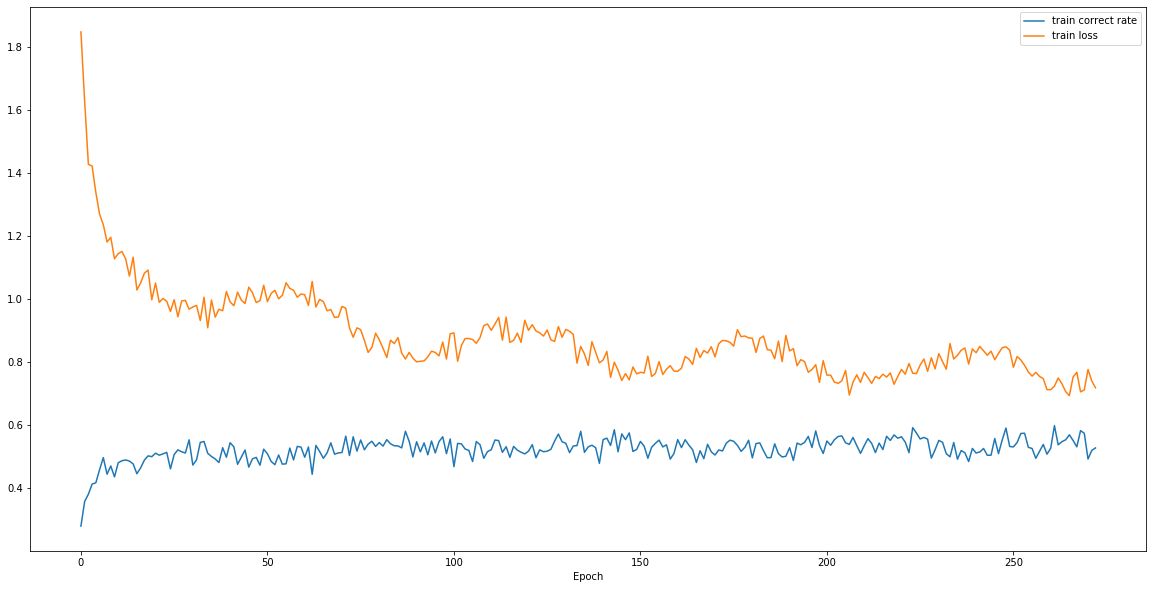

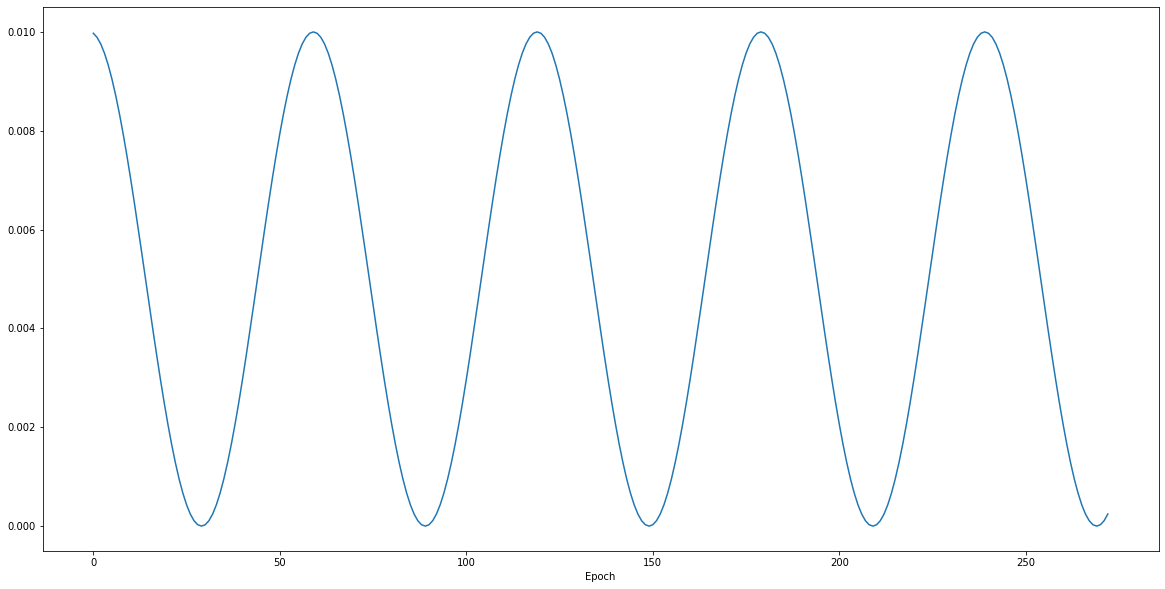

In [24]:
plot_train_info()
plot_lerning_rate()

### Test DenseNet

In [25]:
model_PATH = f"{gd_root}/models/{PATH_Dense}"
test_densenet_net = DenseNet121()
test_densenet_net.to(device)
if device == 'cuda':
    test_densenet_net = torch.nn.DataParallel(test_densenet_net)
    cudnn.benchmark = True
test_densenet_net.load_state_dict(torch.load(model_PATH))

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

<All keys matched successfully>

In [26]:
testing(test_densenet_net)

Progress:  99% |####################### | Elapsed Time: 0:00:08 ETA:   0:00:00 


Accuracy of the network on the 10000 test images: 94.32%


In [27]:
test_for_each(test_densenet_net)

Progress:  99% |####################### | Elapsed Time: 0:00:08 ETA:   0:00:00 


Accuracy of airplane : 98.23%
Accuracy of automobile : 98.26%
Accuracy of bird : 94.08%
Accuracy of cat : 83.72%
Accuracy of deer : 93.94%
Accuracy of dog : 93.81%
Accuracy of frog : 97.52%
Accuracy of horse : 96.88%
Accuracy of ship : 97.35%
Accuracy of truck : 95.59%


---
---
## Run the model in project test data 

### Load test data

In [28]:
project_testset = np.load(f"{gd_root}/data/test_data/y_test.npy").astype(np.uint8)
project_testset = np.moveaxis(project_testset, -1, 2)
project_testset = np.moveaxis(project_testset, 2, 1)
project_testset.shape
type(project_testset)

(12000, 3, 32, 32)

numpy.ndarray

### Convert to DataLoader ([Convertion Reference](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader))

In [29]:
from torch.utils import data
tensor_testset = torch.Tensor(project_testset)
the_dataset = data.TensorDataset(tensor_testset)
project_test_loader = data.DataLoader(the_dataset, 
                                      batch_size=32,
                                      num_workers=8,
                                      pin_memory=True
                                     )
test_batch_len = len(project_test_loader)

### Run the test

In [30]:
predict_result = []

In [31]:
def run_project_test(net, model_path):
    net.load_state_dict(torch.load(model_path))
    
    test_pbar = progress_bar(test_batch_len)
    
    with torch.no_grad():
        for index, imgs in enumerate(project_test_loader):
            
            imgs = torch.stack([torch.Tensor(i) for i in imgs]).squeeze()
            
            if device == 'cuda':
                imgs.cuda()
                
            outputs = net(imgs)
            _, predicted = torch.max(outputs.data, 1)
            
            for p in predicted:
                predict_result.append(p.item())
            
            test_pbar.update(index)
      
    print_time_and_msg(f"Testd {len(predict_result)} images")

In [32]:
model_PATH = f"{gd_root}/models/{PATH_Dense}"  # PATH_DPN
# p_test_net = DPN92()
p_test_net = DenseNet121()
if device == 'cuda':
    p_test_net.to(device)
    p_test_net = torch.nn.DataParallel(p_test_net)
    cudnn.benchmark = True
run_project_test(p_test_net, model_PATH)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Progress:  99% |####################### | Elapsed Time: 0:00:09 ETA:   0:00:00 

[16:34:23] - Testd 12000 images


### Save to csv file

In [33]:
def save_to_csv(result: list):
    result_df = pd.DataFrame(
        list(predict_result),
        columns=["Category"]
    )
    result_df.index.name = "Index"
    print(result_df.shape)
    result_df.to_csv(f"{gd_root}/predict_result.csv")

In [34]:
save_to_csv(predict_result)

(12000, 1)
